# Hydrologic Model Data Preparation and Documentation

## Data Loading

### Variables
- `Q`: Streamflow in millimeters (mm), loaded from a CSV file. Represents the amount of water flowing through a section of a stream or river.
- `Dates`: Dates associated with each measurement in the format [year, month, day].
- `Precip`: Precipitation in millimeters (mm), indicating the amount of rain, snow, sleet, or hail that falls.
- `e`: Vapor pressure in kilopascals (kPa), representing the pressure exerted by water vapor in the air.
- `u2`: Wind speed at 2 meters above the ground in meters per second (m/s).
- `S_in`: Incoming solar radiation in watts per square meter (W/m²), indicating the power of the sun's radiation reaching a given area.
- `Temp`: Temperature in degrees Celsius (°C), measuring the warmth or coldness of the air.
- `Lat_Lon_A_Z`: A matrix containing the latitude, longitude, catchment area, and elevation (Z) for a specific location.

## Model Calculations

### Net Longwave Radiation Calculation (`Rso_calc`)
- Calculates `Rso` (clear sky solar radiation) and `Ra` (extraterrestrial radiation), both crucial for determining the amount of solar energy reaching the Earth's surface.

### Daily Potential Evapotranspiration (PET) Calculation
- Utilizes the Penman-Monteith equation to estimate the rate at which water is evaporated from the surface and transpired by plants.
- `cp`: Specific heat at constant pressure (kJ/(kg·K)), affecting the heat exchange with the air.
- `lambda_`: Latent heat of vaporization (kJ/kg), energy required to change water from liquid to gas.
- `rho_air`: Density of air (kg/m³), influencing the capacity of air to hold water vapor.
- `ra`: Aerodynamic resistance (s/m), resistance to vapor flow imposed by the air layer.
- `rs`: Surface resistance (s/m), resistance to vapor flow from the surface.
- `Rn_RC`: Net radiation over a reference crop (W/m²), the balance between incoming and outgoing radiation.
- `e_sat`: Saturated vapor pressure (kPa), the maximum pressure of water vapor at a given temperature.
- `D`: Vapor pressure deficit (kPa), difference between actual and saturated vapor pressures.
- `Delta`: Slope of the saturation vapor pressure curve (kPa/°C), indicating the change in saturation vapor pressure with temperature.
- `Z`: Elevation (m), affecting air pressure and, consequently, evaporation rates.
- `Press`: Air pressure (kPa) at elevation `Z`, influencing vapor pressure and density.
- `gamma`: Psychrometric constant (kPa/°C), relating the vapor pressure curve to temperature.
- `Wm2_mm`: Conversion factor from W/m² to mm/day, used to convert energy units to depth of water.

### Output Variables for Model Simulation (`toymodel`)
- `Ea`: Actual evapotranspiration, the sum of evaporation and plant transpiration from the Earth's land and ocean surface to the atmosphere.
- `QF`: Quick flow or fast runoff, rapid surface runoff or immediate response in streamflow to precipitation.
- `R`: Recharge to the saturated zone, water that percolates down through the soil to the groundwater.
- `QS`: Slow flow or baseflow, the delayed flow in a stream primarily from groundwater.
- `QT`: Total flow, the sum of quick flow and slow flow.
- `Sf`: Storage in the fast flow reservoir, water temporarily stored before contributing to quick flow.
- `Su`: Storage in the unsaturated zone, water held in the soil layer above the groundwater table.
- `Ss`: Storage in the saturated zone, water within the groundwater or aquifer.
- `St`: Total storage, the sum of unsaturated and saturated zone storage.
- `AL`: Fraction of precipitation contributing to runoff, indicating the proportion of rainfall not absorbed by the soil.
- `IE`: Effective infiltration, the portion of precipitation that contributes to the fast flow.
- `SE`: Saturation excess overland flow, surface runoff occurring when the soil is saturated.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from Rso_calc import Rso_calc
import toymodel as tm

# 1 - Load Data
Q = np.loadtxt('Data/Q_mm.csv', delimiter=',')   # Q in mm
Dates = Q[:, :3]
Precip = np.loadtxt('Data/Precip.csv', delimiter=',') # P in mm
e = np.loadtxt('Data/e.csv', delimiter=',')      # e in kPa
u2 = np.loadtxt('Data/u2.csv', delimiter=',')    # Wind Speed at 2m in m/s
S_in = np.loadtxt('Data/S_in.csv', delimiter=',') # Solar radiation in W/m2
Temp = np.loadtxt('Data/Temp.csv', delimiter=',') # Temp in Celsius
Lat_Lon_A_Z = np.loadtxt('Data/Lat_Lon_Area_Z.csv', delimiter=',') # Lat, Lon, Area, Z

# Remove first 3 columns from each array
Q = Q[:, 3:]
Precip = Precip[:, 3:]
e = e[:, 3:]
u2 = u2[:, 3:]
S_in = S_in[:, 3:]
Temp = Temp[:, 3:]


In [8]:
# 2.1 - Generate Daily PET: Calculate Net Longwave
Ra, Rso = Rso_calc(Dates, Lat_Lon_A_Z[:, 0], Lat_Lon_A_Z[:, 1], Lat_Lon_A_Z[:, 3])

Rso = Rso / (10**-6 * 60 * 60 * 24) # Convert to W/m2
Ra = Ra / (10**-6 * 60 * 60 * 24)   # Convert to W/m2

f = S_in / Rso
e_prime = 0.34 - 0.14 * np.sqrt(e / 1000)
L_net = -f * e_prime * 5.67 * 10**-8 * (Temp + 273.15)**4

# 2.2 - Generate Daily PET:
cp = 1.1013  # specific heat at constant pressure for air kJ/(kg.K)
lambda_ = 1000 * (2.501 - 0.002361 * Temp)  # Latent Heat of Vaporization (kJ/kg)
rho_air = 1.23
ra = 208 / u2
rs = 70
Rn_RC = S_in * (1 - 0.23) + L_net  # Net Radiation over a Reference Crop, in W/m2
e_sat = 0.6108 * np.exp((17.27 * Temp) / (237.3 + Temp))  # Saturated Vapor Pressure in kPa
D = e_sat - e  # Vapor Pressure Deficit in kPa
Delta = 4098 * e_sat / (237.3 + Temp)**2  # Slope of esat versus temp curve (kPa/C)
Z = Lat_Lon_A_Z[:, 3]  # Elevation (m)
Press = 101.3 * ((293 - 0.0065 * Z) / 293)**5.26  # Pressure as function of elevation (kPa)
gamma = cp * Press / (0.622 * lambda_)  # Psychrometric Constant (kPa/degC)

Wm2_mm = (lambda_ * 1000)**-1 * 86400  # Conversion Factor from W/m2 to mm/day

E_RC = (Delta * Rn_RC + rho_air * cp * D / ra) / (Delta + gamma * (1 + rs / ra)) # Evapotranspiration of a reference crop in W/m2

E_RC_mm = E_RC * Wm2_mm
Rn_RC_mm = Rn_RC * Wm2_mm



<Figure size 640x480 with 0 Axes>

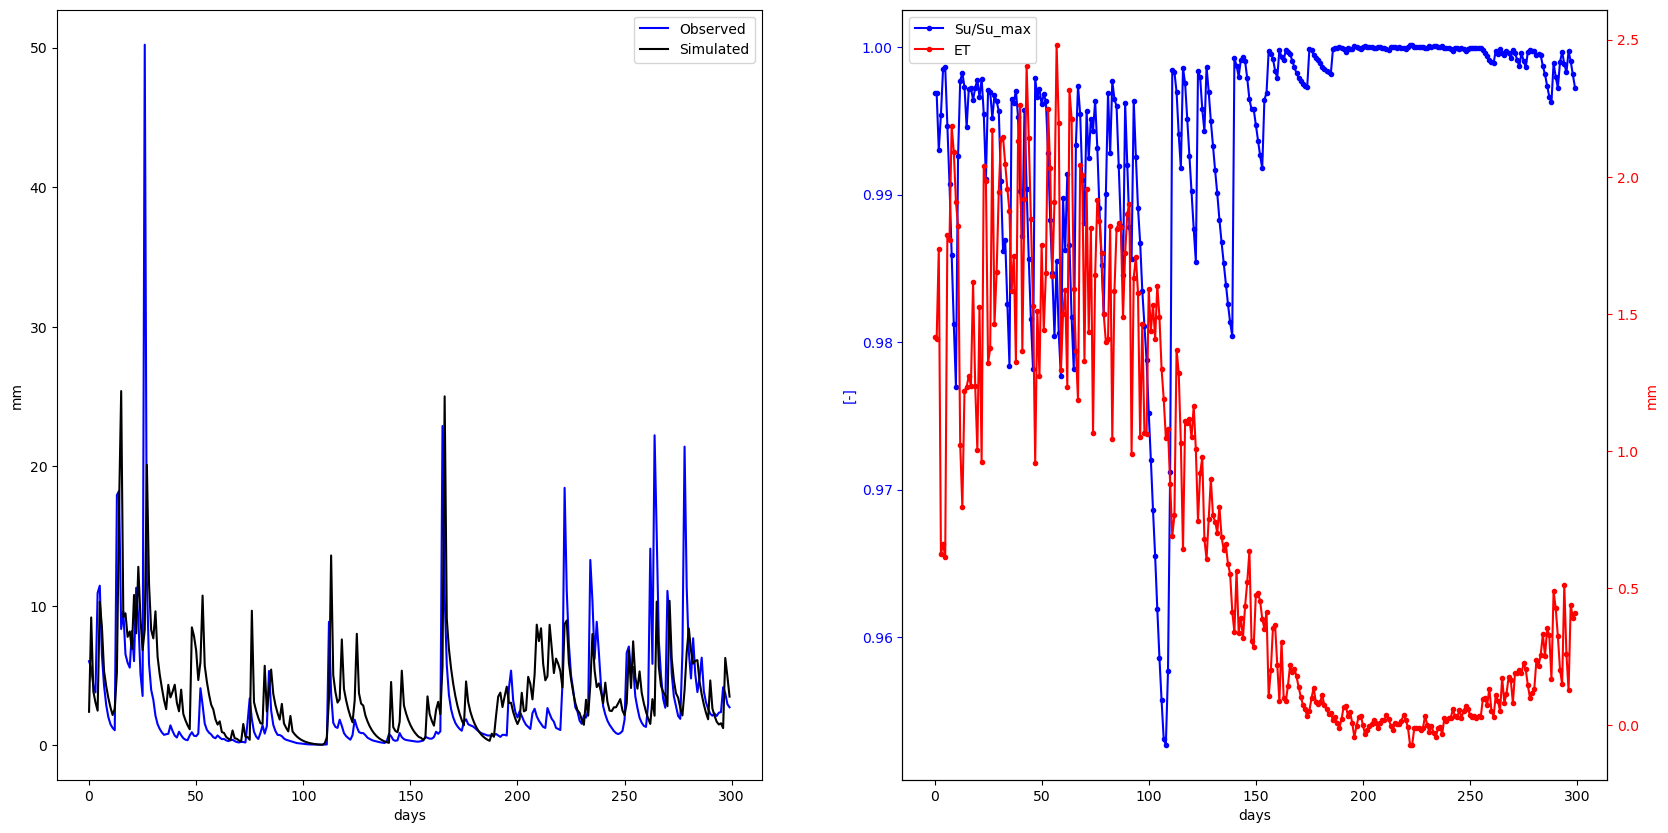

In [13]:
from_index = 500
to_index = 800
pick_catchment = 7  # Python indexing starts from 0

INPUT = np.zeros((Precip.shape[0], 2))
INPUT[:, 0] = Precip[:, pick_catchment]
INPUT[:, 1] = E_RC_mm[:, pick_catchment]

PAR = [50, 450, 5, 1]  # Parameters
Su_max = PAR[1]

Ea, QF, R, QS, QT, Sf, Su, Ss, St, AL, IE, SE = tm.toymodel(INPUT, PAR)




plt.figure(1)
plt.figure(figsize=(20, 10))  # Width, Height in inches
plt.clf()

plt.subplot(1, 2, 1)
plt.plot(Q[from_index:to_index, pick_catchment], '-b', label='Observed')
plt.plot(QT[from_index:to_index], '-k', label='Simulated')
plt.legend()
plt.ylabel('mm')
plt.xlabel('days')

plt.subplot(1, 2, 2)
plt.xlabel('days')
p1, = plt.plot(Su[from_index:to_index] / Su_max, '.-b', label='Su/Su_max')
plt.ylabel('[-]', color='b')  # Set y-label color to blue to match the data
plt.tick_params(axis='y', colors='b')  # Set tick color to blue to match the data
ax2 = plt.twinx()
p2, = ax2.plot(Ea[from_index:to_index], '.-r', label='ET')
ax2.set_ylabel('mm', color='r')  # Set y-label color to red to match the data
ax2.tick_params(axis='y', colors='r')  # Set tick color to red to match the data
handles = [p1, p2]
labels = [h.get_label() for h in handles]
plt.legend(handles, labels, loc='upper left')

plt.show()

#save plt to CIVE 625\Lab 2\Results\Catchment 13.png
#plt.savefig('CIVE 625\Lab 2\Results\Catchment 13.png')